In [3]:
#Importation des bibilotèques python

from os import listdir, chdir, getcwd
from os.path import isfile, join, abspath

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# Fichiers est une liste contenant le nom de tout les fichier de données

fichiers = [f for f in listdir("Dataset") if isfile(join("Dataset", f))]


In [5]:
# Création d'une liste de données (data). Chaque élément de la liste (data[i]) est un fichier NETCDF4 

data = []

for i in range(len(fichiers)) :
    data.append(nc.Dataset('Dataset/' + fichiers[i]))

In [52]:
# Création des variables contenant les grandeurs d'interet 

second = data[1].variables['time'][:]
day = data[1].variables['day'][:]
year = data[1].variables['year'][:]
xco2 = data[1].variables['xco2'][:]


# Création d'une dataframe pandas. Chaque clé du dico correpond à une colonne
a1 = pd.DataFrame({'second': second,'day': day, 'year': year,'xco2': xco2  })




# Autre façon de faire, les années et les jours deviennent des sous labels plutot que des colonnes.
# Peut être pratique
arrays = [
    np.array(year),
    np.array(day),
]

a2 = pd.DataFrame({'xCO2':xco2}, index=arrays)
a2.index.names = (['year','day'])

In [63]:
# Calcul de la moyenne utilisant la première methode

# Groupby permet de sectionner la dataframe selon les valeurs des colonnes spécifiées
day_mean_xco2 = a1.groupby(['year','day'])['xco2'].mean()   # Moyenne journaliere de xCO2 
day_count_measurement = a1.groupby(['year','day'])['xco2'].count() # Nombre de mesure de dans la journée 


In [64]:
day_mean_xco2

year  day
2017  62     406.665558
      63     406.573944
      64     406.628235
      65     406.442139
      66     406.305939
                ...    
2021  113    418.740784
      116    418.901672
      117    419.663666
      118    419.202576
      120    418.994751
Name: xco2, Length: 670, dtype: float32

In [68]:
day_count_measurement

year  day
2017  62     176
      63     401
      64     324
      65     276
      66     397
            ... 
2021  113     90
      116     72
      117    145
      118    170
      120    158
Name: xco2, Length: 670, dtype: int64

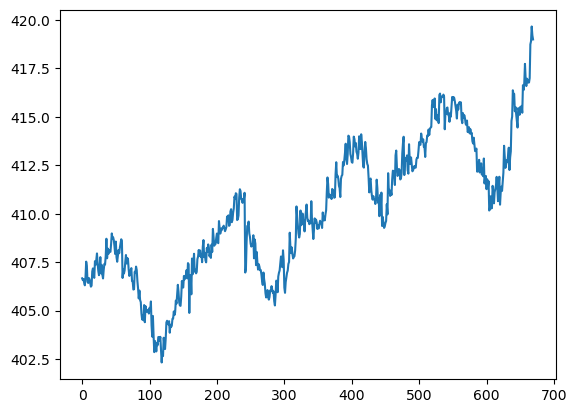

In [69]:
plt.plot(range(len(day_mean_xco2)),day_mean_xco2)